<a href="https://colab.research.google.com/github/drwatson93/M2-A3/blob/main/M2_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This assignment is to practice SVM classification, PCA dimensionality reduction, and multi-classtext classification.The goal is to select and train a classificationmodel for “Consumer Complaint Database”. You can download the CSVfile from this link: https://catalog.data.gov/dataset/consumer-complaint-database

1. Load data and remove all the rows before year “2021” (filter based on “Datereceived”). This dataset is huge,so we keep only year 2021 to make it a reasonablesize for this assignment.

2. Also drop any row thathas the following products(compositeproducts)

*   a.'Credit reporting, credit repair services, or other personal consumer reports'
* b.'Credit card or prepaid card'
* c.'Checking or savings account'
* d.'Bank account or service'
* e.'Money transfer, virtual currency, or money service'
* f.'Payday loan, title loan, or personal loan'

3. Remove every columnexcept “Product”and“Consumer complaint narrative”. We want to predict “product”from “Consumer complaint narrative” text.

4. Plot a bar chart to shows the distribution of samples by product. Isthe dataset balanced?

5. The main issue for this job is how to encode text to a vector of numbers. We will discus different encoding methodsin module 4 of this program, butfor now we will use “TD-IDF”method. Wewill use the encoder from “sklearn”blindly. If you are interested to learn more, you can read this article: https://medium.com/analytics-vidhya/tf-idf-term-frequency-technique-easiest-explanation-for-text-classification-in-nlp-with-code-8ca3912e58c3

6. Use “TfidfVectorizer”from “sklearn.feature_extraction.text”to extract “td-idf”vectorfor “Consumer complaint narrative”. Use the following parameters:

*   a.stop_words='english'
*   b.sublinear_tf=True
* c.ngram_range=(1, 2)

7. Use the“td-idf”vector as input features to your model(note how bigthe vector is). For the output,use product classes.

8. Our goal is to train SVM classification models. Given the very high number of inputfeatures, it can be very slow (you can try to see it for yourself). Let’s use PCA to reduce the numberof dimensions significantly. Find the number of principal components to preserveminimum 90% variability in data. It may take a few minutes forPCA to run. If your computerhad memory issue, you coulduse IncrementalPCA.

9. Try to find the best SVC model (using cross-validation). Try to find the best combination of the following hyperparameters. Don’t useGridSearchas it can be slow. Use your own logic to find the best combination by selecting some candidates smartly.Even though the dataset is not balanced, but you can still use “accuracy”for cross-validation(you can’t use “roc_auc”for multi-class).

*   C
*   Kernel
* Gamma

10. Report the accuracy of cross validationand compareit toaccuracy on training data. Do you see any sign of “underfitting”or “overfitting”?

11. Print and plot confusionmatrix for theselectedmodel. Analyzethe result.



In [31]:
import pandas as pd
import numpy as np
import re
import sklearn
from scipy import sparse
import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix


In [32]:
#1. Load data and remove all the rows before year “2021” (filter based on “Datereceived”). This dataset is huge,so we keep only year 2021 to make it a reasonablesize for this assignment.
db_link = "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"
complaint_df = pd.read_csv(db_link)

In [33]:
# filtering dataset by year 2021
year = 2021
complaint_df['Date received'] = pd.to_datetime(complaint_df['Date received'])
is_2021 = complaint_df['Date received'].dt.year == year
complaint_df_2021 = complaint_df[is_2021]
complaint_df_2021.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
3,2021-03-30,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",LA,705XX,NaN,NaN,Web,2021-03-30,Closed with explanation,Yes,NaN,4253621
9,2021-03-26,"Credit reporting, credit repair services, or o...",Credit reporting,Unable to get your credit report or credit score,Other problem getting your report or credit score,NaN,NaN,Experian Information Solutions Inc.,GA,303XX,NaN,NaN,Web,2021-03-26,In progress,Yes,NaN,4250366
15,2021-03-23,"Money transfer, virtual currency, or money ser...",Foreign currency exchange,Fraud or scam,NaN,NaN,NaN,Square Inc.,CA,91387,NaN,NaN,Web,2021-03-23,Closed with explanation,Yes,NaN,4239229
29,2021-04-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,NaN,National Consumer Telecom & Utilities Exchange...,FL,32818,NaN,NaN,Web,2021-04-05,Closed with explanation,Yes,NaN,4270994
37,2021-04-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,310XX,NaN,NaN,Web,2021-04-05,In progress,Yes,NaN,4272430


In [34]:
#2. Also drop any row that has the following products(compositeproducts)
complaint_df_2021['Product'].unique()

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Money transfer, virtual currency, or money service',
       'Credit card or prepaid card', 'Debt collection', 'Mortgage',
       'Vehicle loan or lease', 'Checking or savings account',
       'Payday loan, title loan, or personal loan', 'Student loan'],
      dtype=object)

In [35]:
product_to_drop = ['Credit reporting, credit repair services, or other personal consumer reports',
                   'Credit card or prepaid card', 
                   'Checking or savings account', 
                   'Bank account or service', 
                   'Money transfer, virtual currency, or money service', 
                   'Payday loan, title loan, or personal loan']
complaint_df_2021_filtered = complaint_df_2021[~complaint_df_2021['Product'].isin(product_to_drop)]
complaint_df_2021_filtered['Product'].unique()

array(['Debt collection', 'Mortgage', 'Vehicle loan or lease',
       'Student loan'], dtype=object)

In [36]:
#3.Remove every columnexcept “Product”and“Consumer complaint narrative”. We want to predict “product”from “Consumer complaint narrative” text.
complaint_df_2021_filtered_final = complaint_df_2021_filtered[['Product','Consumer complaint narrative']]
complaint_df_2021_filtered_final["Product"].value_counts()

Debt collection          17235
Mortgage                  7244
Vehicle loan or lease     1931
Student loan              1075
Name: Product, dtype: int64

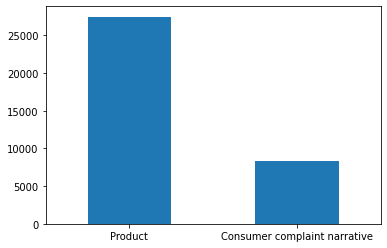

In [37]:
# 4. Plot a bar chart to shows the distribution of samples by product. Isthe dataset balanced? 
complaint_df_2021_filtered_final.count().plot.bar(rot=0)

In [38]:
# Dropping all empty spaces in Consumer complaint narrative
complaint_df_2021_filtered_final.replace(r'^\s+$', np.nan, regex=True)
complaint_df_2021_filtered_final.dropna(subset=['Consumer complaint narrative'], inplace=True)
complaint_df_2021_filtered_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8344 entries, 70268 to 805639
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       8344 non-null   object
 1   Consumer complaint narrative  8344 non-null   object
dtypes: object(2)
memory usage: 195.6+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
# We are now reducing the dataset to 25% of its original size for usability
sample_df = complaint_df_2021_filtered_final.sample(frac=0.25)

In [40]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 730822 to 641946
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       2086 non-null   object
 1   Consumer complaint narrative  2086 non-null   object
dtypes: object(2)
memory usage: 48.9+ KB


In [41]:
# 6. Use “TfidfVectorizer”from “sklearn.feature_extraction.text”to extract “td-idf”vectorfor “Consumer complaint narrative”. Use the following parameters:
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, ngram_range=(1,2))
X_complaint = vectorizer.fit_transform(sample_df['Consumer complaint narrative'])
X_complaint = X_complaint.toarray()
print(np.shape(X_complaint))
print(type(X_complaint))

(2086, 114040)
<class 'numpy.ndarray'>


In [42]:
# 7. Let’s use PCA to reduce the numberof dimensions significantly. Find the number of principal components to preserveminimum 90% variability in data. 
# It may take a few minutes forPCA to run. If your computerhad memory issue, you coulduse IncrementalPCA.
pca = PCA()
pca.fit(X_complaint)
cumsum = np.cumsum(pca.explained_variance_ratio_)
top_d = np.argmax(cumsum >= 0.90) + 1

In [43]:
top_d

1641

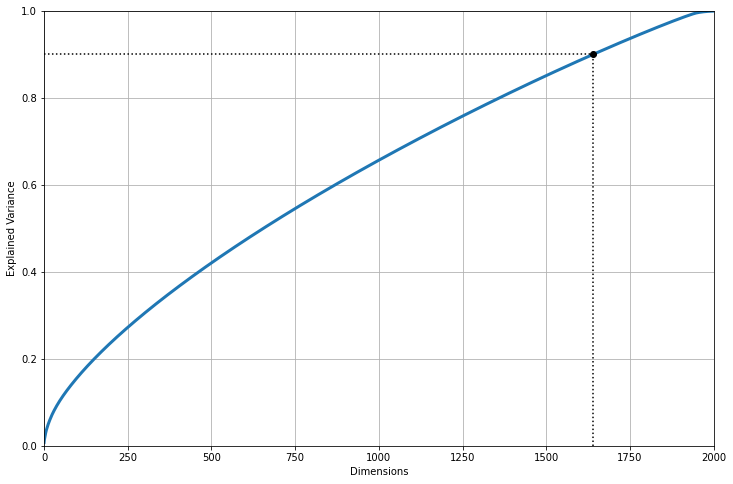

In [44]:
# Ploting dimessional curve.
plt.figure(figsize=(12,8))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 2000, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([top_d, top_d], [0, 0.90], "k:")
plt.plot([0, top_d], [0.90, 0.90], "k:")
plt.plot(top_d, 0.90, "ko")
plt.grid(True)
plt.show()

In [ ]:
# creating PCA with best componetns to retain 90% of data.
pca = PCA(n_components = top_d, random_state=RANDOM_STATE)
X_complaint_reduced = pca.fit_transform(X_complaint)

In [ ]:
print(np.sum(pca.explained_variance_ratio_))
print(type(X_complaint_reduced))
print(X_complaint_reduced.shape)

0.8777114401417037
<class 'numpy.ndarray'>
(2086, 1602)


In [ ]:
# Need to train an linearSVC, SGDClassifier, SVC on a split data
X_complaint_train, X_complaint_test, y_complaint_train, y_complaint_test  = train_test_split(X_complaint_reduced, sample_df["Product"], test_size=0.3, random_state=RANDOM_STATE)

In [ ]:
#SVC
svc_clf = svm.SVC(kernel='linear', C=1, gamma='scale').fit(X_complaint_train, y_complaint_train)
scores = cross_val_score(svc_clf, X_complaint_train, y_complaint_train, cv=5, scoring='accuracy')

In [ ]:
print(svc_clf.score(X_complaint_test, y_complaint_test)
print(scores)
print(np.mean(scores)

0.9
[0.88013699 0.90068493 0.87671233 0.88356164 0.87671233]
0.88


In [ ]:
def gridsearch(model, params):
    gs = GridSearchCV(model, params, verbose = 2, cv = 5, scoring = 'accuracy', n_jobs = -1)
    gs.fit(X_complaint_train, y_complaint_train)
    print('\nBest params: ', gs.best_params_)
    print('\nBest estimator: ', gs.best_estimator_,)
    print('\nBest auc on training set: ', gs.best_score_)
    print('\nBest auc on test set: ', gs.score(X_complaint_test, y_complaint_test))
    return gs.best_estimator_

In [ ]:
svc_clf = svm.SVC()
grid_params = {
    'kernel': ['linear', 'poly'],
    'C': [1, 5, 10],
    'gamma': [0.1, 5]
}

best_svc_model = gridsearch(svc_clf, grid_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.4min finished



Best params:  {'C': 5, 'gamma': 0.1, 'kernel': 'linear'}

Best estimator:  SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Best auc on training set:  0.9006849315068493

Best auc on test set:  0.9057507987220448


In [ ]:
# matrix and metrics report 
y_pred = best_svc_model.predict(X_complaint_test)
print(confusion_matrix(y_complaint_test, y_pred))
print(classification_report(y_complaint_test, y_pred))

[[358   8   0   1]
 [  7 177   0   2]
 [  5   7   9   0]
 [ 15  14   0  23]]
                       precision    recall  f1-score   support

      Debt collection       0.93      0.98      0.95       367
             Mortgage       0.86      0.95      0.90       186
         Student loan       1.00      0.43      0.60        21
Vehicle loan or lease       0.88      0.44      0.59        52

             accuracy                           0.91       626
            macro avg       0.92      0.70      0.76       626
         weighted avg       0.91      0.91      0.90       626



Confusion matrix, without normalization
[[358   8   0   1]
 [  7 177   0   2]
 [  5   7   9   0]
 [ 15  14   0  23]]
Normalized confusion matrix
[[0.97547684 0.02179837 0.         0.0027248 ]
 [0.03763441 0.9516129  0.         0.01075269]
 [0.23809524 0.33333333 0.42857143 0.        ]
 [0.28846154 0.26923077 0.         0.44230769]]


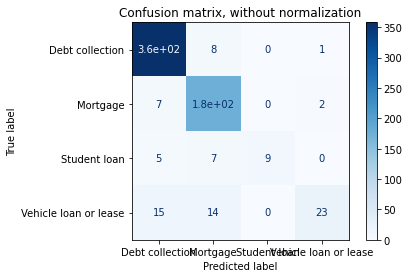

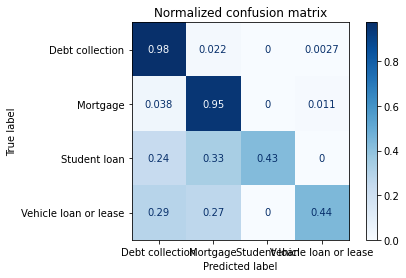

In [ ]:
# plotting confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(best_svc_model, X_complaint_test, y_complaint_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
# testing with no PCA on 25% dataset after TfidfVectorizer.

# split data
X_complaint_train, X_complaint_test, y_complaint_train, y_complaint_test  = train_test_split(X_complaint, sample_df["Product"], test_size=0.3, random_state=RANDOM_STATE)
print('X_train Dataset shape: {}'.format(X_complaint_train.shape))
print('X_test Dataset shape: {}'.format(X_complaint_test.shape))
print('y_train Dataset shape: {}'.format(y_complaint_train.shape))
print('y_test Dataset shape: {}'.format(y_complaint_test.shape))

X_train Dataset shape: (1460, 114040)
X_test Dataset shape: (626, 114040)
y_train Dataset shape: (1460,)
y_test Dataset shape: (626,)


In [ ]:
svc_clf = svm.SVC(kernel='linear', C=5, gamma=0.1).fit(X_complaint_train, y_complaint_train)
scores = cross_val_score(svc_clf, X_complaint_train, y_complaint_train, cv=5, scoring='accuracy')

In [ ]:
y_pred = svc_clf.predict(X_complaint_test)
print(confusion_matrix(y_complaint_test, y_pred))
print(classification_report(y_complaint_test, y_pred))

[[361   6   0   0]
 [  6 179   0   1]
 [  5   9   7   0]
 [ 18  14   0  20]]
                       precision    recall  f1-score   support

      Debt collection       0.93      0.98      0.95       367
             Mortgage       0.86      0.96      0.91       186
         Student loan       1.00      0.33      0.50        21
Vehicle loan or lease       0.95      0.38      0.55        52

             accuracy                           0.91       626
            macro avg       0.93      0.67      0.73       626
         weighted avg       0.91      0.91      0.89       626



Confusion matrix, without normalization
[[361   6   0   0]
 [  6 179   0   1]
 [  5   9   7   0]
 [ 18  14   0  20]]
Normalized confusion matrix
[[0.98365123 0.01634877 0.         0.        ]
 [0.03225806 0.96236559 0.         0.00537634]
 [0.23809524 0.42857143 0.33333333 0.        ]
 [0.34615385 0.26923077 0.         0.38461538]]


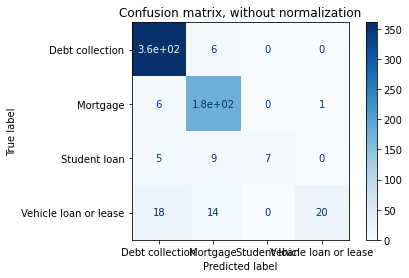

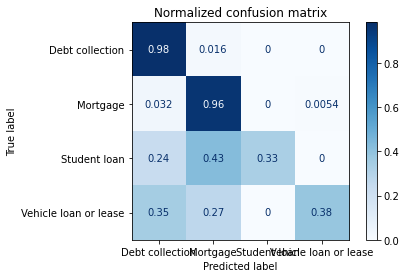

In [30]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svc_clf, X_complaint_test, y_complaint_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()